## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. токенизация
2. приведение к нижнему регистру
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать параметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split 

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
clothes = pd.read_csv('/content/drive/MyDrive/data/women-clothing-accessories.csv', sep='\t', usecols=[0, 1])

clothes

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive
89997,спасибо большое ) продовца рекомендую.. заказа...,positive
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive


In [4]:
X_train, X_test, y_train, y_test = train_test_split(clothes.review, clothes.sentiment, train_size = 0.7)

**Выполним предобработку текста:**  
- токенизация

In [5]:
import nltk
from nltk.tokenize import word_tokenize

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
X_train = X_train.apply(word_tokenize)
X_test = X_test.apply(word_tokenize)

X_train

3693     [ПРОДАВЕЦ, ЛЖЕЦ, НИЧЕГО, У, НЕГО, НЕ, ЗАКАЗЫВА...
72467    [Плотные, ,, хорошего, качества, ,, на, женски...
69975    [Заказ, пришел, быстро, ., На, 44, р-р, М, как...
41229                                  [товар, не, пришёл]
68017    [платье, заказывала, маме, ,, качество, отличн...
                               ...                        
77197                                                 [ok]
82536    [здравствуйте, !, заказ, пришел, меньше, чем, ...
50811    [Размер, маленький, ., На, талии, плохо, тянутся]
55599    [Ставлю, три, звезды, за, несоответствие, разм...
14162    [Когда, заказывала, ,, выбрала, для, взрослого...
Name: review, Length: 62999, dtype: object

- приведение к нижнему регистру

In [8]:
for item in X_train:
  for i in range(len(item)):
    item[i] = item[i].lower()

for item in X_test:
  for i in range(len(item)):
    item[i] = item[i].lower()

X_train

3693     [продавец, лжец, ничего, у, него, не, заказыва...
72467    [плотные, ,, хорошего, качества, ,, на, женски...
69975    [заказ, пришел, быстро, ., на, 44, р-р, м, как...
41229                                  [товар, не, пришёл]
68017    [платье, заказывала, маме, ,, качество, отличн...
                               ...                        
77197                                                 [ok]
82536    [здравствуйте, !, заказ, пришел, меньше, чем, ...
50811    [размер, маленький, ., на, талии, плохо, тянутся]
55599    [ставлю, три, звезды, за, несоответствие, разм...
14162    [когда, заказывала, ,, выбрала, для, взрослого...
Name: review, Length: 62999, dtype: object

- лемматизация

In [9]:
!pip install pymorphy2

In [10]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [11]:
for item in X_train:
  for i in range(len(item)):
    item[i] = pymorphy2_analyzer.parse(item[i])[0].normal_form

for item in X_test:
  for i in range(len(item)):
    item[i] = pymorphy2_analyzer.parse(item[i])[0].normal_form

- удаление стоп-слов

In [12]:
X_train_copy = X_train
X_test_copy = X_test

In [13]:
from nltk.corpus import stopwords

In [14]:
X_train[1]

['товар',
 'отдать',
 'другой',
 'человек',
 ',',
 'я',
 'не',
 'получить',
 'посылка',
 '.',
 'ладный',
 'хоть',
 'деньга',
 'вернуть',
 '.']

In [15]:
noise = stopwords.words('russian')

for item in X_train:
  for word in item: 
    if word in noise: 
      item.remove(word)

for item in X_test:
  for word in item: 
    if word in noise: 
      item.remove(word)

X_train[1]

['товар',
 'отдать',
 'человек',
 ',',
 'не',
 'получить',
 'посылка',
 '.',
 'ладный',
 'деньга',
 'вернуть',
 '.']

- также удалим пунктуацию

In [16]:
for item in X_train:
  for word in item: 
    if not(word.isalpha()): 
      item.remove(word)

for item in X_test:
  for word in item: 
    if not(word.isalpha()) : 
      item.remove(word)

X_train[1]

['товар',
 'отдать',
 'человек',
 'не',
 'получить',
 'посылка',
 'ладный',
 'деньга',
 'вернуть']

превратим List в String:

In [17]:
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

X_train[1]

'товар отдать человек не получить посылка ладный деньга вернуть'

**Займемся векторизацией:**  
 - векторайзер: мешок n-грамм

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
from sklearn.metrics import * 

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [22]:
import matplotlib.pyplot as plt

In [ ]:
accuracy = []

for i in range(1, 11):
  vectorizer = CountVectorizer(ngram_range=(1, i))
  vectorized_x_train = vectorizer.fit_transform(X_train)

  clf = MultinomialNB()
  clf.fit(vectorized_x_train, y_train)

  vectorized_x_test = vectorizer.transform(X_test)
  pred = clf.predict(vectorized_x_test)
  accuracy.append(accuracy_score(y_test, pred))

Text(0, 0.5, 'Accuracy')

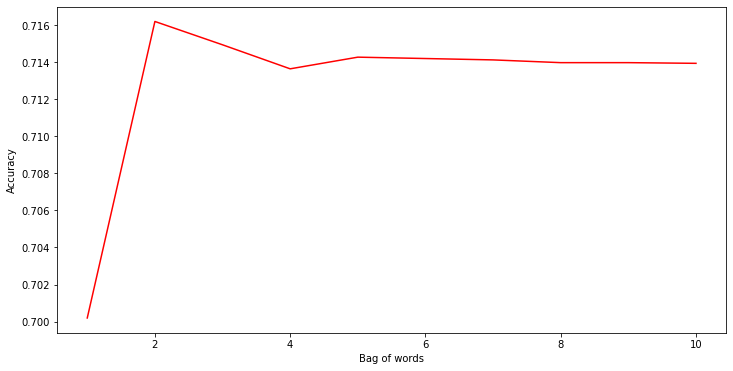

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), accuracy, color='red')
plt.xlabel('Bag of words')
plt.ylabel('Accuracy')

Таким образом, для мешка n-грамм **примем диапазон n = (1, 2)**

- векторайзер: tf-idf (нужно подбирать параметры nram_range, max_df, min_df, max_features)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__min_df": (0.01, 0.05, 0.1, 0.2),
    'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2), (1, 3), (1, 4)),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 71.7min finished


0.6678677433457179


In [ ]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=0.01, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Таким образом, для TFIDF **примем диапазон n = (1, 1), max_df=0.5, max_features=None, min_df=0.01**

- векторайзер: символьные n-граммы

In [ ]:
accuracy = []

for i in range(3, 16):
  vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, i))
  vectorized_x_train = vectorizer.fit_transform(X_train)

  clf = MultinomialNB()
  clf.fit(vectorized_x_train, y_train)

  vectorized_x_test = vectorizer.transform(X_test)
  pred = clf.predict(vectorized_x_test)
  accuracy.append(accuracy_score(y_test, pred))

Text(0, 0.5, 'Accuracy')

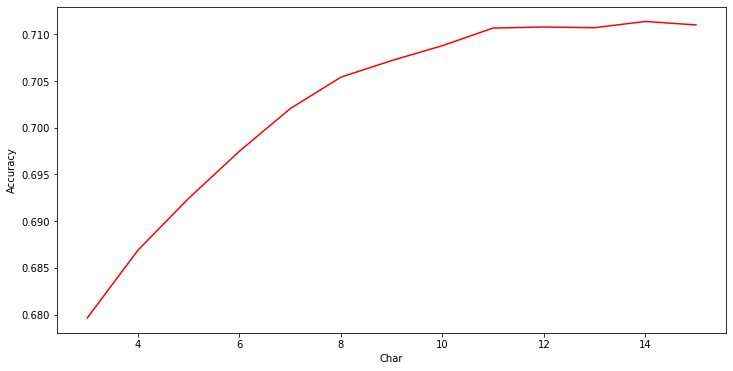

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(3, 16), accuracy, color='red')
plt.xlabel('Char')
plt.ylabel('Accuracy')

Таким образом, для символьных n-грамм **примем диапазон n = (3, 14)**

Оценим качества моделей (precision, recall, f1-score и accuracy):

In [24]:
vectorizer1 = CountVectorizer(ngram_range=(1, 2))
vectorized_x_train1 = vectorizer1.fit_transform(X_train)

clf1 = MultinomialNB()
clf1.fit(vectorized_x_train1, y_train)

vectorized_x_test1 = vectorizer1.transform(X_test)
pred1 = clf1.predict(vectorized_x_test1)

In [25]:
vectorizer2 = TfidfVectorizer(max_df=0.5, max_features=None, min_df=0.01, ngram_range=(1, 1))
vectorized_x_train2 = vectorizer2.fit_transform(X_train)

clf2 = MultinomialNB()
clf2.fit(vectorized_x_train2, y_train)

vectorized_x_test2 = vectorizer2.transform(X_test)
pred2 = clf2.predict(vectorized_x_test2)

In [26]:
vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3, 14))
vectorized_x_train3 = vectorizer3.fit_transform(X_train)

clf3 = MultinomialNB()
clf3.fit(vectorized_x_train3, y_train)

vectorized_x_test3 = vectorizer3.transform(X_test)
pred3 = clf3.predict(vectorized_x_test3)

In [27]:
data = {'Precision':[precision_score(y_test, pred1, average='weighted'), precision_score(y_test, pred2, average='weighted'), precision_score(y_test, pred3, average='weighted')],
        'Recall':[recall_score(y_test, pred1, average='weighted'), recall_score(y_test, pred2, average='weighted'), recall_score(y_test, pred3, average='weighted')],
        'F1-Score':[f1_score(y_test, pred1, average='weighted'), f1_score(y_test, pred2, average='weighted'), f1_score(y_test, pred3, average='weighted')],
        'Accuracy':[accuracy_score(y_test, pred1), accuracy_score(y_test, pred2), accuracy_score(y_test, pred3)]}

df = pd.DataFrame(data, index =['Мешок n-грамм',
                                'TFIDF',
                                'Символьные n-граммы'])
df

,Precision,Recall,F1-Score,Accuracy
Мешок n-грамм,0.724227,0.721196,0.721944,0.721196
TFIDF,0.688411,0.675419,0.678588,0.675419
Символьные n-граммы,0.721164,0.719159,0.719782,0.719159


Таким образом, лучшие результаты показал векторайзер - **мешок n-грамм**

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [29]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [30]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [31]:
s = "some string and nothing else"

result = re.findall(r'\b\w{2}', s)
print(result)

['so', 'st', 'an', 'no', 'el']


### split
разделяет строку по заданному шаблону


In [32]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [33]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [34]:
s = "Sentence 1. Sentence 2. Sentence 3. Sentence 4."

result = re.split(r'\.', s, maxsplit=2)
print(result)

['Sentence 1', ' Sentence 2', ' Sentence 3. Sentence 4.']


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [35]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [36]:
s = "Some string with 1234 numbers 5678"

result =  re.sub(r'\d+', 'DIG', s)
print(result)

Some string with DIG numbers DIG


**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [37]:
s = "Learn web-programming with https://developer.mozilla.org"

result = re. sub(r'http\S+', '', s)
print(result)

Learn web-programming with 


### compile
компилирует регулярное выражение в отдельный объект

In [38]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [39]:
s = "some string and may be other info"

result = re.compile(r'\w{4,}')
result.findall(s)

['some', 'string', 'other', 'info']

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [40]:
s = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"

result = re.compile(r'@\w+.\w+')
result.findall(s)

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']